Convolutional neural nets encode structural priors

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F


from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

from idlmam import train_simple_network, set_seed

In [3]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

torch.backends.cudnn.deterministic=True
set_seed(1)

<ipython-input-3-ec05cfbb3f04>:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


In [4]:
import torchvision
from torchvision import transforms

We can consider image data to have the shape

$(N, W, H)$

or

$(N, C, W, H)$

to include color channels

In [5]:
mnist_data_train = torchvision.datasets.MNIST("./data", train=True, download=True)
mnist_data_test = torchvision.datasets.MNIST("./data", train=False, download=True)
x_example, y_example = mnist_data_train[0]
type(x_example) # PIL.image.image because images!

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16207710.58it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 486805.45it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4432772.13it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10923468.33it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



PIL.Image.Image

In [6]:
# transform from image to tensor
mnist_data_train = torchvision.datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_data_test = torchvision.datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())
x_example, y_example = mnist_data_train[0]
print(x_example.shape)

torch.Size([1, 28, 28])


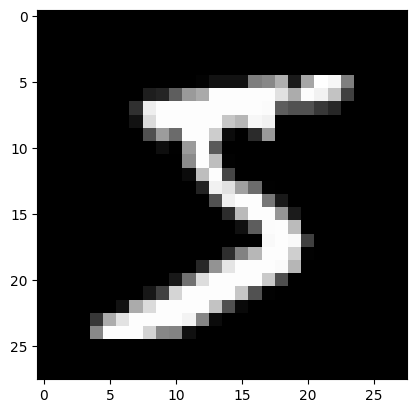

In [7]:
imshow(x_example[0,:], cmap='gray')

In [8]:
# stack along dim 0, makes a 'channeled' image
x_as_color = torch.stack([x_example[0,:], x_example[0,:], x_example[0,:]], dim=0)
print(x_as_color.shape)

torch.Size([3, 28, 28])


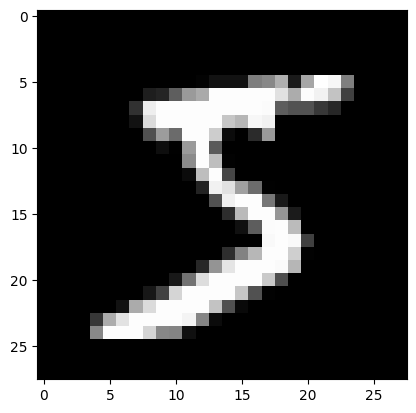

In [9]:
imshow(x_as_color.permute(1,2,0)) # permute because imshow expects W,H,C

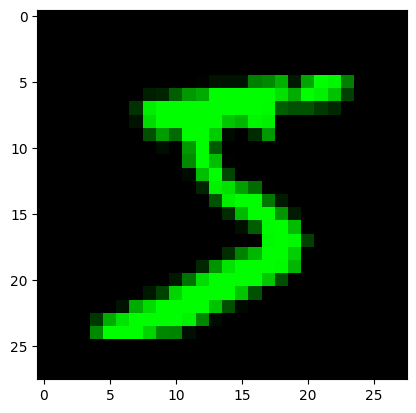

In [10]:
# turn off red and blue channels (RGB), black and white before because R=G=B= black and white.
x_as_color = torch.stack([x_example[0,:], x_example[0,:], x_example[0,:]])
x_as_color[0,:] = 0 #No Red
#Leaving green alone
x_as_color[2,:] = 0 #No Blue
imshow(x_as_color.permute(1,2,0))

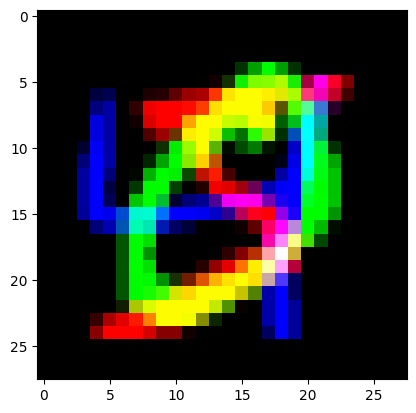

In [11]:
#grab 3 images
x1, x2, x3 = mnist_data_train[0], mnist_data_train[1], mnist_data_train[2]
#drop the labels
x1, x2, x3 = x1[0], x2[0], x3[0]
x_as_color = torch.stack([x1[0,:], x2[0,:], x3[0,:]], dim=0)
imshow(x_as_color.permute(1,2,0))

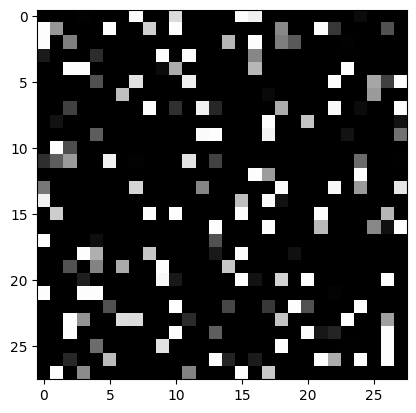

In [12]:
rand_order = torch.randperm(x_example.shape[1] * x_example.shape[2])
x_shuffled = x_example.view(-1)[rand_order].view(x_example.shape)
imshow(x_shuffled[0,:], cmap='gray')

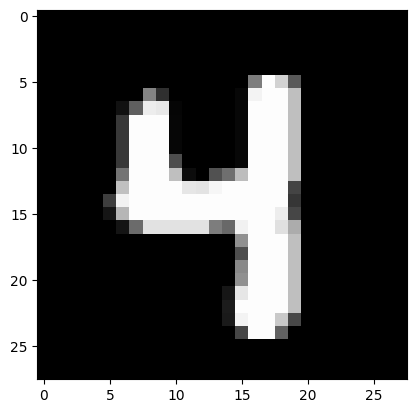

In [13]:
from scipy.signal import convolve
img_indx = 58
img = mnist_data_train[img_indx][0][0,:]
plt.imshow(img, vmin=0, vmax=1, cmap='gray')

A filter/kernel must have the exact same number of channels as the images coming into it.

Filters define what kind of "pattern" to look for. The more convolutions you have, the more patterns you can detect.

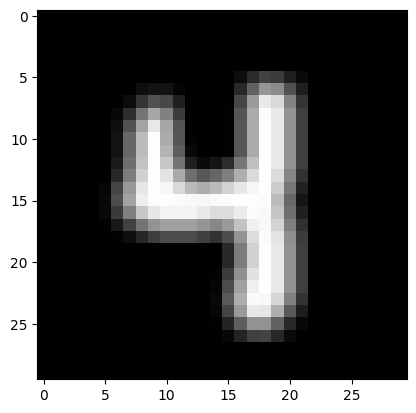

In [15]:
blur_filter = np.asarray([[1,1,1],
                          [1,1,1],
                          [1,1,1]
                         ])/9.0

blurry_img = convolve(img, blur_filter)
plt.imshow(blurry_img, vmin=0, vmax=1, cmap='gray')
plt.show()

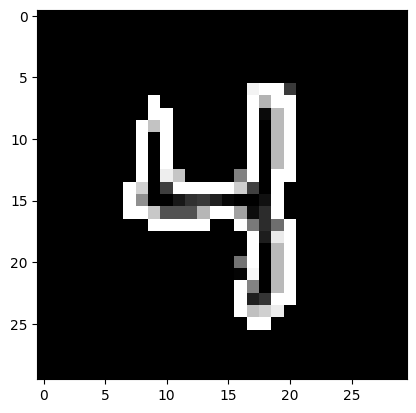

In [17]:
#We can find edges by focusing on the difference between a pixel, and its neighbors
edge_filter = np.asarray([[-1,-1,-1],
                          [-1, 8,-1],
                          [-1,-1,-1]
                         ])


edge_img = convolve(img, edge_filter)
plt.imshow(edge_img, vmin=0, vmax=1, cmap='gray')
plt.show()

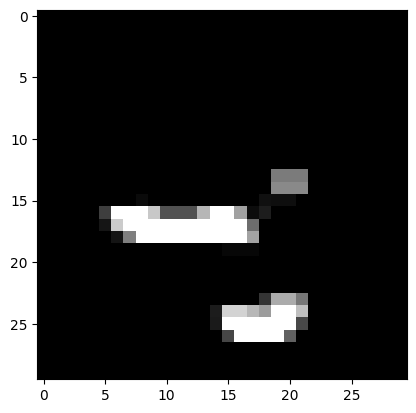

In [18]:
#We could look for only horizontal edges
h_edge_filter = np.asarray([[-1,-1,-1],
                          [0, 0,0],
                          [1, 1, 1]
                         ])


h_edge_img = convolve(img, h_edge_filter)
plt.imshow(h_edge_img, vmin=0, vmax=1, cmap='gray')
plt.show()

Convolving an input with a filter means pairwise multiplication of the filter values at each location and summing them all up

To determine the size of the output image after applying a convolutional filter to an input image, you can use the following mathematical formulation.

### Definitions:
- $ w $: Width of the input image
- $ h $: Height of the input image
- $ n $: Size (width and height) of the filter (assuming it's a square filter)
- $ p $: Padding (number of pixels added to the border of the image) (because we don't want the input to disappear after multiple convolutions) (e.g., zero padding adds zeros around the image)
- $ s $: Stride (number of pixels the filter moves at each step)

### Formula for Output Dimensions:
The output dimensions (width and height) of the image after applying the convolutional filter can be calculated using the following formulas:

$ \text{Output Width} = \left\lfloor \frac{w - n + 2p}{s} \right\rfloor + 1 $
$ \text{Output Height} = \left\lfloor \frac{h - n + 2p}{s} \right\rfloor + 1 $

where:
- $ \left\lfloor \cdot \right\rfloor $ denotes the floor function, which rounds down to the nearest integer.

### Explanation:
1. **$ w - n $** and **$ h - n $**: These terms represent the reduction in width and height due to the size of the filter. Each application of the filter reduces the dimensions of the image by $ n-1 $ pixels.
2. **$ + 2p $**: This term accounts for padding. Padding adds pixels around the border of the image, which can help preserve the spatial dimensions of the input image.
3. **$ / s $**: Dividing by the stride accounts for the step size of the filter. If the stride is greater than 1, the filter moves more than one pixel at a time, which reduces the size of the output image.
4. **$ + 1 $**: This term accounts for the initial position of the filter at the start of the convolution process.

### Example Calculation:
Let's consider a specific example to illustrate this. Suppose you have:
- An input image of size $ 1 \times 5 \times 5 $ (width $ w = 5 $, height $ h = 5 $)
- A filter of size $ 3 \times 3 $ (filter size $ n = 3 $)
- No padding ($ p = 0 $)
- A stride of $ 1 $ ($ s = 1 $)

Using the formulas:

$ \text{Output Width} = \left\lfloor \frac{5 - 3 + 0}{1} \right\rfloor + 1 = \left\lfloor \frac{2}{1} \right\rfloor + 1 = 2 + 1 = 3 $

$ \text{Output Height} = \left\lfloor \frac{5 - 3 + 0}{1} \right\rfloor + 1 = \left\lfloor \frac{2}{1} \right\rfloor + 1 = 2 + 1 = 3 $

So, the output image size after convolution would be $ 1 \times 3 \times 3 $.

To keep the same image size, if filter size is K, then use padding of $\lfloor{K/2}\rfloor$

**Convolutions are Linear Operations that Work Spatially**
Therefore, don't include one after the other (because this is just another linear opeation/convolution), put a nonlinear function between them.

In [19]:
device = torch.device("cuda") if torch.cuda.is_aavailable() else torch.device("cpu")

B = 32
mnist_train_loader = DataLoader(mnist_data_train, batch_size=B, shuffle=True)
mnist_test_loader = DataLoader(mnist_data_test, batch_size=B)

Represent all filters as $G \in \mathbb{R}^{C_{out}, C_{input}, K, K}$

C_out is number of different filters, C_in is input channels

$R = Input \circledast G$

$R \in \mathbb{R}^{K,W',H'}$

in `nn.Conv2d(C_in, C_out, K, padding = K//2)`, an image comes in as input with C_in channels, each filter of the C_out filters is applied one at a time, producing a single output channel, and every output channel is combined into one new image with C_out channels

Let's write out the mathematical formulations for both models in terms of weights, biases, and functions.

### Convolutional Neural Network (`model_cnn`)

1. **First Conv2D Layer**:
   - Input: $\mathbf{x} \in \mathbb{R}^{B \times 1 \times 28 \times 28}$
   - Weights: $\mathbf{W}_{conv} \in \mathbb{R}^{16 \times 1 \times 3 \times 3}$
   - Biases: $\mathbf{b}_{conv} \in \mathbb{R}^{16}$
   - Convolution Operation:
  $$
     \mathbf{h}_{conv, c} = \mathbf{x} \circledast \mathbf{W}_{conv, c} + \mathbf{b}_{conv, c} \quad \text{for} \; c = 1, \ldots, 16
  $$
     where $\circledast$ denotes the convolution operation, and $c$ indexes the output channels (filters).
   - Output: $\mathbf{h}_{conv} \in \mathbb{R}^{B \times 16 \times 28 \times 28}$

2. **Tanh Activation Function**:
   - Input: $\mathbf{h}_{conv} \in \mathbb{R}^{B \times 16 \times 28 \times 28}$
   - Output: $\mathbf{a}_{conv} = \tanh(\mathbf{h}_{conv})$
   - Dimensions: $(B, 16 \times 28 \times 28) \rightarrow (B, 16 \times 28 \times 28)$

3. **Flatten Layer**:
   - Input: $\mathbf{a}_{conv} \in \mathbb{R}^{B \times 16 \times 28 \times 28}$
   - Output: $\mathbf{a}_{flat} \in \mathbb{R}^{B \times 12544}$
   - For a $28 \times 28$ image with 16 channels: $ 16 \times 28 \times 28 = 12544 $
   - Dimensions: $(B, 16 \times 28 \times 28) \rightarrow (B, 12544)$

4. **Linear Layer**:
   - Input: $\mathbf{a}_{flat} \in \mathbb{R}^{B \times 12544}$
   - Weights: $\mathbf{W}_{fc} \in \mathbb{R}^{10 \times 12544}$
   - Biases: $\mathbf{b}_{fc} \in \mathbb{R}^{10}$
   - Output: $\mathbf{y} = \mathbf{a}_{flat} \mathbf{W}_{fc}^\top + \mathbf{b}_{fc}$
   - Dimensions: $(B, 12544) \rightarrow (B, 10)$

### Summary of Formulations

#### Linear Model:
1. **Flatten**:
$$
   \mathbf{x} \in \mathbb{R}^{B \times 1 \times 28 \times 28} \rightarrow \mathbf{x}_{flat} \in \mathbb{R}^{B \times 784}
$$
2. **First Linear Layer**:
$$
   \mathbf{h}_1 = \mathbf{x}_{flat} \mathbf{W}_1^\top + \mathbf{b}_1 \quad \mathbf{W}_1 \in \mathbb{R}^{256 \times 784}, \; \mathbf{b}_1 \in \mathbb{R}^{256}
$$
3. **Tanh Activation**:
$$
   \mathbf{a}_1 = \tanh(\mathbf{h}_1)
$$
4. **Second Linear Layer**:
$$
   \mathbf{y} = \mathbf{a}_1 \mathbf{W}_2^\top + \mathbf{b}_2 \quad \mathbf{W}_2 \in \mathbb{R}^{10 \times 256}, \; \mathbf{b}_2 \in \mathbb{R}^{10}
$$

#### Convolutional Neural Network:
1. **Conv2D Layer**:
$$
   \mathbf{h}_{conv, c} = \mathbf{x} \circledast \mathbf{W}_{conv, c} + \mathbf{b}_{conv, c} \quad \mathbf{W}_{conv} \in \mathbb{R}^{16 \times 1 \times 3 \times 3}, \; \mathbf{b}_{conv} \in \mathbb{R}^{16}
$$
2. **Tanh Activation**:
$$
   \mathbf{a}_{conv} = \tanh(\mathbf{h}_{conv})
$$
3. **Flatten**:
$$
   \mathbf{a}_{flat} = \text{flatten}(\mathbf{a}_{conv}) \quad \mathbf{a}_{flat} \in \mathbb{R}^{B \times 12544}
$$
4. **Linear Layer**:
$$
   \mathbf{y} = \mathbf{a}_{flat} \mathbf{W}_{fc}^\top + \mathbf{b}_{fc} \quad \mathbf{W}_{fc} \in \mathbb{R}^{10 \times 12544}, \; \mathbf{b}_{fc} \in \mathbb{R}^{10}
$$

These formulations represent the linear transformations and activations applied at each layer of the models.

With each C_out, nn.conv2d kindly stacks the output for each filter for us.

Put simply:

$f(x) = \text{tanh}\left(x_{C_{in}, W, H} \circledast W^{(h_1)}_{C_{out},C_{in},K,K}\right)W^{(out)}_{(C_{out}\cdot w \cdot h), C} = \text{tanh}\left(x \circledast W^{(h_1)}\right)W^{(out)}$

In [ ]:
#How many values are in the input? We use this to help determine the size of subsequent layers
D = 28*28 #28 * 28 images
#How many channels are in the input?
C = 1
#How many classes are there?
classes = 10
#How many filters should we use
filters = 16
#how large should our filters be?
K = 3
#for comparison, lets define a linear model of similar complexity
model_linear = nn.Sequential(
  nn.Flatten(), #(B, C, W, H) -> (B, C*W*H) = (B,D)
  nn.Linear(D, 256),
  nn.Tanh(),
  nn.Linear(256, classes),
)

#A simple convolutional network:
model_cnn = nn.Sequential(
  #Conv2d follows the pattern of:
  #Conv2d(# of input channels, #filters/output-channels, #filter-size)
  nn.Conv2d(C, filters, K, padding=K//2), #$x \circledast G$
  nn.Tanh(),#Activation functions work on any size tensor
  nn.Flatten(), #Convert from (B, C, W, H) ->(B, D). This way we can use a Linear layer after
  nn.Linear(filters*D, classes),
)

In [ ]:
loss_func = nn.CrossEntropyLoss()
cnn_results = train_simple_network(model_cnn, loss_func, mnist_train_loader, test_loader=mnist_test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=20)
fc_results = train_simple_network(model_linear, loss_func, mnist_train_loader, test_loader=mnist_test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=20)

<AxesSubplot:xlabel='epoch', ylabel='test Accuracy'>

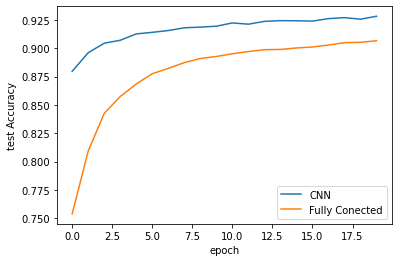

In [ ]:
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results, label='CNN')
sns.lineplot(x='epoch', y='test Accuracy', data=fc_results, label='Fully Conected')

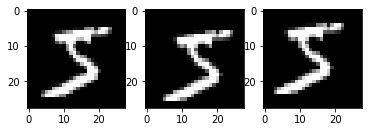

In [ ]:
img_indx = 0
img, correct_class = mnist_data_train[img_indx]
img = img[0,:]
#move to the lower right, then upper left
img_lr = np.roll(np.roll(img, 1, axis=1), 1, axis=0)
img_ul = np.roll(np.roll(img, -1, axis=1), -1, axis=0)
#plot the images
f, axarr = plt.subplots(1,3)
axarr[0].imshow(img, cmap='gray')
axarr[1].imshow(img_lr, cmap='gray')
axarr[2].imshow(img_ul, cmap='gray')
plt.show()

In [ ]:
#eval mode since we are not training
model = model_cnn.cpu().eval()

def pred(model, img):
    with torch.no_grad():#Always turn off gradients when evaluating
        w, h = img.shape#Whats the width/height of the image
        if not isinstance(img, torch.Tensor):
            img = torch.tensor(img)
        x = img.reshape(1,-1,w,h)#reshape it as (B, C, W, H)
        logits = model(x) #Get the logits
        y_hat = F.softmax(logits, dim=1)#Turn into probabilities
        return y_hat.numpy().flatten()#convert prediction to numpy array.

Small changes to the same input cause big changes in model confidence in the output class! We introduce pooling to try and make the model more robust to translational variance - we desire the property known as translational invariance

In [ ]:
img_pred = pred(model, img)
img_lr_pred = pred(model, img_lr)
img_ul_pred = pred(model, img_ul)

print("Org Img Class {} Prob:         ".format(correct_class) , img_pred[correct_class])
print("Lower Right Img Class {} Prob: ".format(correct_class) , img_lr_pred[correct_class])
print("Uper Left Img Class {} Prob:   ".format(correct_class) , img_ul_pred[correct_class])

Org Img Class 5 Prob:          0.78159285
Lower Right Img Class 5 Prob:  0.44280732
Uper Left Img Class 5 Prob:    0.31534675


In [ ]:
model_cnn_pool = nn.Sequential(
  nn.Conv2d(C, filters, 3, padding=3//2),
  nn.Tanh(),
  nn.Conv2d(filters, filters, 3, padding=3//2),
  nn.Tanh(),
  nn.Conv2d(filters, filters, 3, padding=3//2),
  nn.Tanh(),
  nn.MaxPool2d(2),
  nn.Conv2d(filters, 2*filters, 3, padding=3//2),
  nn.Tanh(),
  nn.Conv2d(2*filters, 2*filters, 3, padding=3//2),
  nn.Tanh(),
  nn.Conv2d(2*filters, 2*filters, 3, padding=3//2),
  nn.Tanh(),
  nn.MaxPool2d(2),

  nn.Flatten(),
  #Why did we reduce the number of units into the Linear layer by a factor of $4^2$? Because pooling a 2x2 grid down to one value means we go from 4 values, down to 1, and we did this two times.
  nn.Linear(2*filters*D//(4**2), classes),
)

cnn_results_with_pool = train_simple_network(model_cnn_pool, loss_func, mnist_train_loader, test_loader=mnist_test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=20)

In [ ]:
model = model_cnn_pool.cpu().eval()
img_pred = pred(model, img)
img_lr_pred = pred(model, img_lr)
img_ul_pred = pred(model, img_ul)

print("Org Img Class {} Prob:         ".format(correct_class) , img_pred[correct_class])
print("Lower Right Img Class {} Prob: ".format(correct_class) , img_lr_pred[correct_class])
print("Uper Left Img Class {} Prob:   ".format(correct_class) , img_ul_pred[correct_class])

Org Img Class 5 Prob:          0.7068047
Lower Right Img Class 5 Prob:  0.71668524
Uper Left Img Class 5 Prob:    0.7311974


<AxesSubplot:xlabel='epoch', ylabel='test Accuracy'>

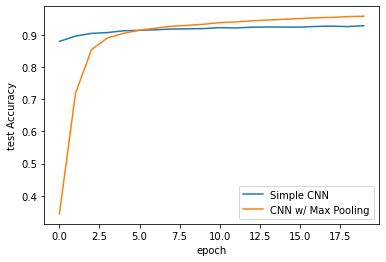

In [ ]:
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results, label='Simple CNN')
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results_with_pool, label='CNN w/ Max Pooling')

In addition to pooling, we can augment data with random transformations.

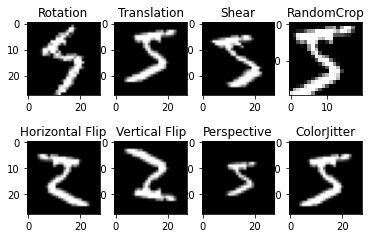

In [ ]:
#Several built-in transformations, given some agressive values to make their impact more obvious.
sample_transforms = {
    "Rotation" : transforms.RandomAffine(degrees=45),
    "Translation" : transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
    "Shear": transforms.RandomAffine(degrees=0, shear=45),
    "RandomCrop" : transforms.RandomCrop((20,20)),
    "Horizontal Flip" : transforms.RandomHorizontalFlip(p=1.0),
    "Vertical Flip": transforms.RandomVerticalFlip(p=1.0),
    "Perspective": transforms.RandomPerspective(p=1.0),
    "ColorJitter" : transforms.ColorJitter(brightness=0.9, contrast=0.9)
}
#Convert the Tensor image back to a PIL image using a transform
pil_img = transforms.ToPILImage()(img)
#Plot a randomy application of each transform
f, axarr = plt.subplots(2,4)
for count, (name, t) in enumerate(sample_transforms.items()):
    row = count % 4
    col = count // 4
    axarr[col,row].imshow(t(pil_img), cmap='gray')
    axarr[col,row].set_title(name)
plt.show()

num_workers controls how many threads are used to preload batches of data for training. CPU processes the image while GPU processes the data.

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.98, 1.02)),
    transforms.ToTensor(),
])

test_transform = transforms.ToTensor()

mnist_train_t = torchvision.datasets.MNIST("./data", train=True, transform=train_transform)
mnist_test_t = torchvision.datasets.MNIST("./data", train=False, transform=test_transform)
mnist_train_loader_t = DataLoader(mnist_train_t, shuffle=True,  batch_size=B, num_workers=5)
mnist_test_loader_t = DataLoader(mnist_test_t, batch_size=B, num_workers=5)

In [ ]:
model_cnn_pool = nn.Sequential(
  nn.Conv2d(C, filters, 3, padding=3//2),
  nn.Tanh(),
  nn.Conv2d(filters, filters, 3, padding=3//2),
  nn.Tanh(),
  nn.Conv2d(filters, filters, 3, padding=3//2),
  nn.Tanh(),
  nn.MaxPool2d(2),
  nn.Conv2d(filters, 2*filters, 3, padding=3//2),
  nn.Tanh(),
  nn.Conv2d(2*filters, 2*filters, 3, padding=3//2),
  nn.Tanh(),
  nn.Conv2d(2*filters, 2*filters, 3, padding=3//2),
  nn.Tanh(),
  nn.MaxPool2d(2),
  nn.Flatten(),
  nn.Linear(2*filters*D//(4**2), classes),
)

cnn_results_with_pool_augmented = train_simple_network(model_cnn_pool, loss_func, mnist_train_loader_t, test_loader=mnist_test_loader_t, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=20)

<AxesSubplot:xlabel='epoch', ylabel='test Accuracy'>

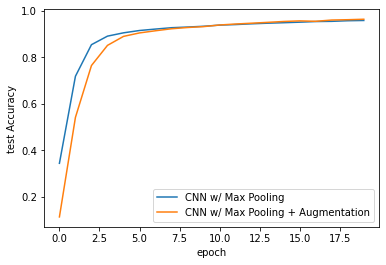

In [ ]:
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results_with_pool, label='CNN w/ Max Pooling')
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results_with_pool_augmented, label='CNN w/ Max Pooling + Augmentation')